# **Recommendation System: Anime**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import seaborn as sns
sns.set(style='darkgrid',font_scale=1.5)
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from collections import Counter

#Data Preparation
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Modeling eval
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity


import warnings
warnings.filterwarnings('ignore')

# Data Loading

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("CooperUnion/anime-recommendations-database")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/anime-recommendations-database


In [ ]:
# loding data
anime = pd.read_csv(path + '/anime.csv')
rating = pd.read_csv(path + '/rating.csv')

# Data Understanding


In [ ]:
# Membaca 5 baris data anime
anime.head()

,anime_id,name,genre,type,episodes,rating,members
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665
2,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.25,114262
3,9253,Steins;Gate,"Sci-Fi, Thriller",TV,24,9.17,673572
4,9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.16,151266


In [ ]:
# Membaca 5 baris data rating pengguna
rating.head()

,user_id,anime_id,rating
0,1,20,-1
1,1,24,-1
2,1,79,-1
3,1,226,-1
4,1,241,-1


In [ ]:
print("Jumlah data judul anime:", len(anime.anime_id.unique()))
print("Jumlah data pengguna rating:", len(rating.user_id.unique()))

Jumlah data judul anime: 12294
Jumlah data pengguna rating: 73515


#Univariate Exploratory Data Analysis

In [ ]:
anime.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12294 entries, 0 to 12293
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   anime_id  12294 non-null  int64  
 1   name      12294 non-null  object 
 2   genre     12232 non-null  object 
 3   type      12269 non-null  object 
 4   episodes  12294 non-null  object 
 5   rating    12064 non-null  float64
 6   members   12294 non-null  int64  
dtypes: float64(1), int64(2), object(4)
memory usage: 672.5+ KB


In [ ]:
rating.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7813737 entries, 0 to 7813736
Data columns (total 3 columns):
 #   Column    Dtype
---  ------    -----
 0   user_id   int64
 1   anime_id  int64
 2   rating    int64
dtypes: int64(3)
memory usage: 178.8 MB


In [ ]:
print('\nJudul anime: ', anime.name.unique())
print('\nGenre anime: ', anime.genre.unique())
print('\nType anime: ', anime.type.unique())
print('\nEpisode anime: ', anime.episodes.unique())
print('\nRating anime: ', anime.rating.unique())
print('\nMembers anime: ', anime.members.unique())


Judul anime:  ['Kimi no Na wa.' 'Fullmetal Alchemist: Brotherhood' 'Gintama°' ...
 'Violence Gekiga David no Hoshi'
 'Violence Gekiga Shin David no Hoshi: Inma Densetsu'
 'Yasuji no Pornorama: Yacchimae!!']

Genre anime:  ['Drama, Romance, School, Supernatural'
 'Action, Adventure, Drama, Fantasy, Magic, Military, Shounen'
 'Action, Comedy, Historical, Parody, Samurai, Sci-Fi, Shounen' ...
 'Hentai, Sports' 'Drama, Romance, School, Yuri' 'Hentai, Slice of Life']

Type anime:  ['Movie' 'TV' 'OVA' 'Special' 'Music' 'ONA' nan]

Episode anime:  ['1' '64' '51' '24' '10' '148' '110' '13' '201' '25' '22' '75' '4' '26'
 '12' '27' '43' '74' '37' '2' '11' '99' 'Unknown' '39' '101' '47' '50'
 '62' '33' '112' '23' '3' '94' '6' '8' '14' '7' '40' '15' '203' '77' '291'
 '120' '102' '96' '38' '79' '175' '103' '70' '153' '45' '5' '21' '63' '52'
 '28' '145' '36' '69' '60' '178' '114' '35' '61' '34' '109' '20' '9' '49'
 '366' '97' '48' '78' '358' '155' '104' '113' '54' '167' '161' '42' '142'
 '31' '373'

Variabel-variabel pada Anime dataset adalah sebagai berikut:

**Dataset anime.csv**
- `anime_id` : ID unik untuk setiap anime di MyAnimeList
- `name` :Nama lengkap anime
- `genre` : Daftar genre (dipisahkan koma)
- `type` : Jenis anime (TV, Movie, OVA, dll)
- `episodes` : Jumlah episode
- `rating` : Rata-rata skor rating dari pengguna
- `members` : Jumlah anggota komunitas yang mengikuti anime ini

**Dataset rating.csv**
- `user_id` :	ID pengguna (anonim)
- `anime_id` :	ID anime yang dirating
- `rating` :	Nilai rating (1-10), -1 artinya ditonton tapi tidak diberi rating

In [ ]:
anime.describe()

,anime_id,rating,members
count,12294.000000,12064.000000,1.229400e+04
mean,14058.221653,6.473902,1.807134e+04
std,11455.294701,1.026746,5.482068e+04
min,1.000000,1.670000,5.000000e+00
25%,3484.250000,5.880000,2.250000e+02
50%,10260.500000,6.570000,1.550000e+03
75%,24794.500000,7.180000,9.437000e+03
max,34527.000000,10.000000,1.013917e+06


In [ ]:
rating.describe()

,user_id,anime_id,rating
count,7.813737e+06,7.813737e+06,7.813737e+06
mean,3.672796e+04,8.909072e+03,6.144030e+00
std,2.099795e+04,8.883950e+03,3.727800e+00
min,1.000000e+00,1.000000e+00,-1.000000e+00
25%,1.897400e+04,1.240000e+03,6.000000e+00
50%,3.679100e+04,6.213000e+03,7.000000e+00
75%,5.475700e+04,1.409300e+04,9.000000e+00
max,7.351600e+04,3.451900e+04,1.000000e+01


**Insight:**
- Rating tertinggi mencapai 10, dengan rata-rata sekitar 6.48.
- Median (50%) jumlah members adalah 1.552, menandakan sebagian besar anime memiliki basis penggemar yang relatif kecil, dan hanya sebagian kecil yang sangat populer.
- Ada nilai -1 pada kolom rating, yang umumnya menandakan bahwa user belum memberikan rating, hanya menambahkan anime ke daftar mereka
- Rata-rata rating yang diberikan user adalah 6.14, cukup sejalan dengan rata-rata rating dari dataset anime.



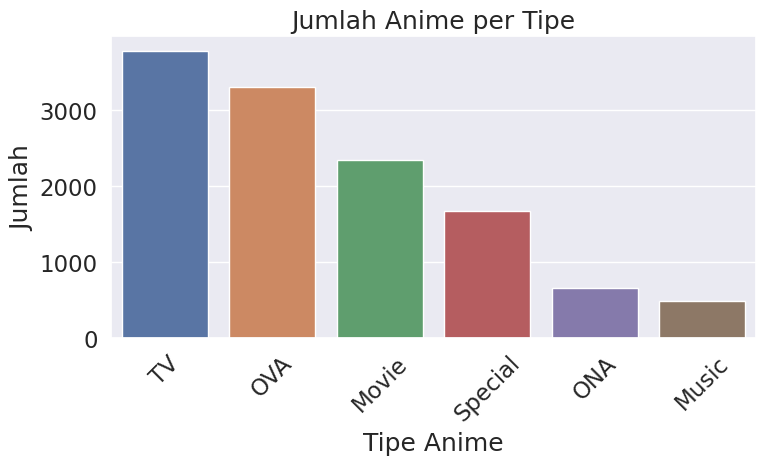

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
sns.countplot(data=anime, x='type', order=anime['type'].value_counts().index)
plt.title('Jumlah Anime per Tipe')
plt.xlabel('Tipe Anime')
plt.ylabel('Jumlah')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#versi tulisan



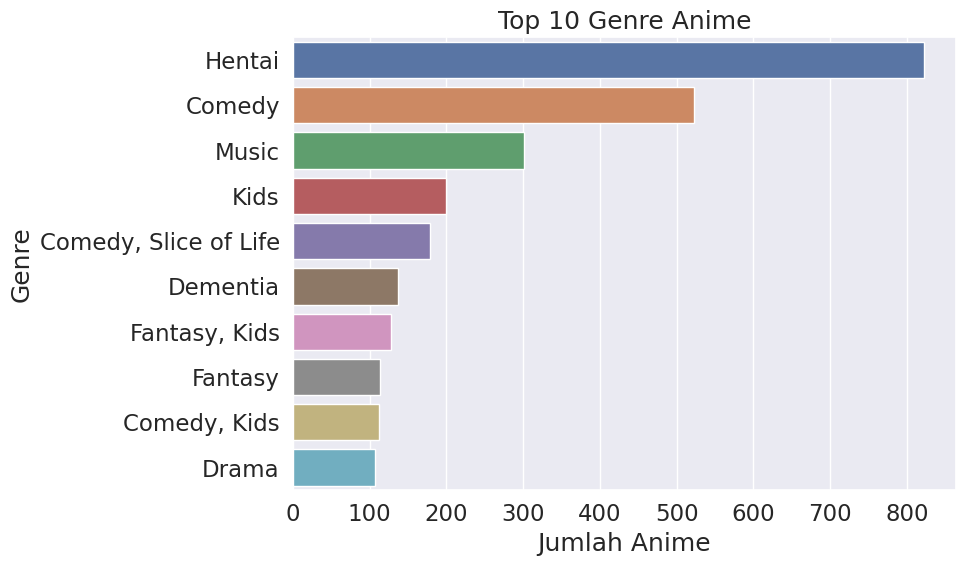

In [ ]:
# Genre Anime

# Pisahkan dan hitung genre
genre_series = anime['genre'].dropna().str.split('|')
genre_counts = Counter([g for sublist in genre_series for g in sublist])
top_genres = dict(genre_counts.most_common(10))

plt.figure(figsize=(10, 6))
sns.barplot(x=list(top_genres.values()), y=list(top_genres.keys()))
plt.title('Top 10 Genre Anime')
plt.xlabel('Jumlah Anime')
plt.ylabel('Genre')
plt.tight_layout()
plt.show()


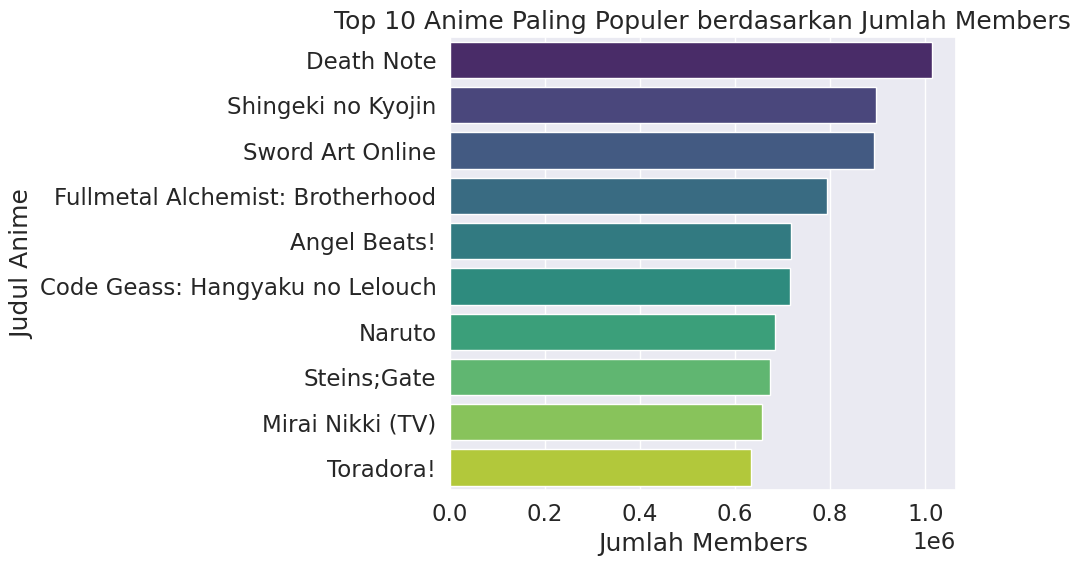

In [ ]:
anime_populer = anime.sort_values(by='members', ascending=False).head(10)
anime_populer[['anime_id', 'name', 'type', 'members']]

plt.figure(figsize=(10, 6))
sns.barplot(data=anime_populer, y='name', x='members', palette='viridis')
plt.title('Top 10 Anime Paling Populer berdasarkan Jumlah Members')
plt.xlabel('Jumlah Members')
plt.ylabel('Judul Anime')
plt.tight_layout()
plt.show()



1. **Jumlah Anime per Tipe**

  Anime TV adalah tipe anime yang paling banyak diproduksi, disusul oleh OVA dan Movie. Ini menunjukkan bahwa TV series adalah format yang paling dominan, kemungkinan karena bisa menjangkau lebih banyak penonton dan menawarkan narasi yang panjang.

2. **Top 10 Genre Anime**
  
  Genre Hentai di posisi pertama, menunjukkan bahwa jumlah judul dalam genre ini sangat banyak. Kemudian disusul comedy, Music, dan Kids.

3. **Top 10 Anime Paling Populer**

  Death Note adalah anime dengan jumlah anggota (members) terbanyak. Anime populer lainnya seperti Attack on Titan (Shingeki no Kyojin), Sword Art Online, dan Fullmetal Alchemist: Brotherhood juga masuk dalam daftar, mencerminkan bahwa anime bergenre aksi, fantasi, dan psikologis memiliki daya tarik besar.


**🔍 Kesimpulan Umum:**

- TV series mendominasi produksi anime, tetapi OVA dan film juga tetap signifikan.
- Genre dan sub-genre yang sangat bervariasi menunjukkan fleksibilitas medium anime dalam menjangkau berbagai demografik.
- Popularitas anime tidak selalu berbanding lurus dengan jumlah genre atau tipe, melainkan dipengaruhi oleh kualitas cerita, daya tarik karakter, dan eksposur global.

In [ ]:
# Jumlah anime unik di anime.csv
print('Banyak anime di anime.csv:', len(anime.anime_id.unique()))

# Jumlah anime unik di rating.csv
print('Banyak anime di rating.csv:', len(rating.anime_id.unique()))

# Jumlah members (user count per anime) dari anime.csv
print('Banyak members di anime.csv:', len(anime.members.unique()))

# Jumlah user unik di rating.csv
print('Banyak user di rating.csv:', len(rating.user_id.unique()))


Banyak anime di anime.csv: 12294
Banyak anime di rating.csv: 11200
Banyak members di anime.csv: 6706
Banyak user di rating.csv: 73515


Jumlah anime di anime.csv lebih banyak daripada di rating.csv:

Tidak semua anime di database anime.csv memiliki rating dari user. Bisa jadi anime tersebut kurang populer atau belum dirating sama sekali oleh pengguna.

In [ ]:
# Cek missing value
anime.isnull().sum()

anime_id      0
name          0
genre        62
type         25
episodes      0
rating      230
members       0
dtype: int64

In [ ]:
rating.isnull().sum()

user_id     0
anime_id    0
rating      0
dtype: int64

# Data Preparation

In [ ]:
#Menggabungkan dataset
anime_rating = pd.merge(anime,rating[["user_id","anime_id","rating"]], on = ["anime_id"],how = "right")
anime_rating.rename(columns = {'rating_x':'AverageRating','rating_y':'rating_user'}, inplace = True)

print("Final Dataset: ")
anime_rating.head()

Final Dataset: 


,anime_id,name,genre,type,episodes,AverageRating,members,user_id,rating_user
0,20,Naruto,"Action, Comedy, Martial Arts, Shounen, Super P...",TV,220,7.81,683297.0,1,-1
1,24,School Rumble,"Comedy, Romance, School, Shounen",TV,26,8.06,178553.0,1,-1
2,79,Shuffle!,"Comedy, Drama, Ecchi, Fantasy, Harem, Magic, R...",TV,24,7.31,158772.0,1,-1
3,226,Elfen Lied,"Action, Drama, Horror, Psychological, Romance,...",TV,13,7.85,623511.0,1,-1
4,241,Girls Bravo: First Season,"Comedy, Ecchi, Fantasy, Harem, Romance, School",TV,11,6.69,84395.0,1,-1


In [ ]:
anime_rating.shape

(7813737, 9)

Penggabungan dataset dilakukan dengan cara right join menggunakan fungsi pd.merge() pada kolom anime_id, sehingga seluruh data dari rating.csv dipertahankan dan hanya informasi anime yang cocok dari anime.csv yang digabungkan. Dataset gabungan memiliki 9 kolom, yaitu: `anime_id`, `name`, `genre`, `type`, `episodes`, `AverageRating`, `members`, `user_id`, dan `rating_user`.

In [ ]:
anime_rating.isnull().sum()

anime_id           0
name              10
genre            120
type              14
episodes          10
AverageRating     16
members           10
user_id            0
rating_user        0
dtype: int64

In [ ]:
#Lihat data yang punya mising value
anime_rating[anime_rating.isnull().any(axis=1)].head()

,anime_id,name,genre,type,episodes,AverageRating,members,user_id,rating_user
111900,28647,Kappo,NaN,Movie,1,4.71,335.0,1145,-1
111901,28653,Maze,NaN,Movie,1,5.37,138.0,1145,-1
111902,28655,PiKA PiKA,NaN,Movie,1,4.92,289.0,1145,-1
111924,28987,Kamakura,NaN,Movie,1,5.53,164.0,1145,-1
203759,33242,IS: Infinite Stratos 2 - Infinite Wedding,NaN,Special,1,7.15,6604.0,2050,7


In [ ]:
#Lihat missing value pada kolom type
anime_rating[anime_rating['type'].isnull()]

,anime_id,name,genre,type,episodes,AverageRating,members,user_id,rating_user
1392686,30913,NaN,NaN,NaN,NaN,NaN,NaN,13270,-1
1969308,30913,NaN,NaN,NaN,NaN,NaN,NaN,19104,-1
1969309,30924,NaN,NaN,NaN,NaN,NaN,NaN,19104,-1
3411438,30484,Steins;Gate 0,"Sci-Fi, Thriller",NaN,Unknown,NaN,60999.0,31437,9
3659298,30913,NaN,NaN,NaN,NaN,NaN,NaN,34240,9
3660124,30913,NaN,NaN,NaN,NaN,NaN,NaN,34248,-1
3959155,30913,NaN,NaN,NaN,NaN,NaN,NaN,37442,9
3961670,30484,Steins;Gate 0,"Sci-Fi, Thriller",NaN,Unknown,NaN,60999.0,37475,7
4478271,30484,Steins;Gate 0,"Sci-Fi, Thriller",NaN,Unknown,NaN,60999.0,42372,9
4811385,30484,Steins;Gate 0,"Sci-Fi, Thriller",NaN,Unknown,NaN,60999.0,45904,9


In [ ]:
#Lihat missing value pada kolom episodes, name, member

anime_rating[anime_rating['episodes'].isnull() | anime_rating['name'].isnull() | anime_rating['members'].isnull()]

,anime_id,name,genre,type,episodes,AverageRating,members,user_id,rating_user
1392686,30913,NaN,NaN,NaN,NaN,NaN,NaN,13270,-1
1969308,30913,NaN,NaN,NaN,NaN,NaN,NaN,19104,-1
1969309,30924,NaN,NaN,NaN,NaN,NaN,NaN,19104,-1
3659298,30913,NaN,NaN,NaN,NaN,NaN,NaN,34240,9
3660124,30913,NaN,NaN,NaN,NaN,NaN,NaN,34248,-1
3959155,30913,NaN,NaN,NaN,NaN,NaN,NaN,37442,9
5104517,20261,NaN,NaN,NaN,NaN,NaN,NaN,48766,-1
5483385,30913,NaN,NaN,NaN,NaN,NaN,NaN,51693,-1
6765685,30913,NaN,NaN,NaN,NaN,NaN,NaN,62549,-1
6765686,30924,NaN,NaN,NaN,NaN,NaN,NaN,62549,-1


In [ ]:
#Lihat missing value pada kolom episodes
anime_rating[anime_rating['AverageRating'].isnull()]

,anime_id,name,genre,type,episodes,AverageRating,members,user_id,rating_user
1392686,30913,NaN,NaN,NaN,NaN,NaN,NaN,13270,-1
1969308,30913,NaN,NaN,NaN,NaN,NaN,NaN,19104,-1
1969309,30924,NaN,NaN,NaN,NaN,NaN,NaN,19104,-1
3411438,30484,Steins;Gate 0,"Sci-Fi, Thriller",NaN,Unknown,NaN,60999.0,31437,9
3659298,30913,NaN,NaN,NaN,NaN,NaN,NaN,34240,9
3660124,30913,NaN,NaN,NaN,NaN,NaN,NaN,34248,-1
3959155,30913,NaN,NaN,NaN,NaN,NaN,NaN,37442,9
3961670,30484,Steins;Gate 0,"Sci-Fi, Thriller",NaN,Unknown,NaN,60999.0,37475,7
4478271,30484,Steins;Gate 0,"Sci-Fi, Thriller",NaN,Unknown,NaN,60999.0,42372,9
4558395,33674,No Game No Life Movie,"Adventure, Comedy, Ecchi, Fantasy, Game, Super...",Movie,1,NaN,32041.0,43480,-1


Karena terdapat banyak kolom dengan baris yang sama memiliki nilai kosong bersamaan pada kolom lain juga, maka penghapusan hanya berdasarkan `genre` dan `AverageRating` sudah cukup mewakili semua missing value untuk membersihkan baris-baris yang tidak lengkap, termasuk yang kolom lainnya yang kosong.



In [ ]:
# Menangani missing value genre anime_rating
anime_rating = anime_rating.dropna(subset=['genre', 'AverageRating'])
anime_rating.isnull().sum()

anime_id         0
name             0
genre            0
type             0
episodes         0
AverageRating    0
members          0
user_id          0
rating_user      0
dtype: int64

In [ ]:
anime_rating.duplicated().sum()

1

In [ ]:
# Hapus data duplikat
anime_rating = anime_rating.drop_duplicates()
anime_rating.duplicated().sum()

0

In [ ]:
anime_rating.shape

(7813610, 9)

In [ ]:
# Mengubah value di rating (rating.csv) when = -1 diubah jadi 0
anime_rating.loc[anime_rating['rating_user'] == -1, 'rating_user'] = 0

anime_rating.head()

,anime_id,name,genre,type,episodes,AverageRating,members,user_id,rating_user
0,20,Naruto,"Action, Comedy, Martial Arts, Shounen, Super P...",TV,220,7.81,683297.0,1,0
1,24,School Rumble,"Comedy, Romance, School, Shounen",TV,26,8.06,178553.0,1,0
2,79,Shuffle!,"Comedy, Drama, Ecchi, Fantasy, Harem, Magic, R...",TV,24,7.31,158772.0,1,0
3,226,Elfen Lied,"Action, Drama, Horror, Psychological, Romance,...",TV,13,7.85,623511.0,1,0
4,241,Girls Bravo: First Season,"Comedy, Ecchi, Fantasy, Harem, Romance, School",TV,11,6.69,84395.0,1,0


In [ ]:
# Ambil hanya kolom relevan dan buang duplikat berdasarkan anime_id untuk model CBF
anime_unique = anime_rating[['anime_id', 'name', 'genre', 'AverageRating']].drop_duplicates('anime_id').copy()


In [ ]:
# TF-IDF vectorizer: tokenisasi berdasarkan koma
tfidf = TfidfVectorizer(tokenizer=lambda x: x.split(', '))

# Melakukan perhitungan idf pada data cuisine
tfidf.fit(anime_unique['genre'])

# Mapping array dari fitur index integer ke fitur nama
tfidf.get_feature_names_out()



array(['action', 'adventure', 'cars', 'comedy', 'dementia', 'demons',
       'drama', 'ecchi', 'fantasy', 'game', 'harem', 'hentai',
       'historical', 'horror', 'josei', 'kids', 'magic', 'martial arts',
       'mecha', 'military', 'music', 'mystery', 'parody', 'police',
       'psychological', 'romance', 'samurai', 'school', 'sci-fi',
       'seinen', 'shoujo', 'shoujo ai', 'shounen', 'shounen ai',
       'slice of life', 'space', 'sports', 'super power', 'supernatural',
       'thriller', 'vampire', 'yaoi', 'yuri'], dtype=object)

In [ ]:
# Melakukan fit lalu ditransformasikan ke bentuk matrix
tfidf_matrix = tfidf.fit_transform(anime_unique['genre'])
print("Shape TF-IDF matrix:", tfidf_matrix.shape)


Shape TF-IDF matrix: (11162, 43)


In [ ]:
# Mengubah vektor tf-idf dalam bentuk matriks dengan fungsi todense()
tfidf_matrix.todense()

matrix([[0.31444719, 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        ...,
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.64080823, 0.        , ..., 0.        , 0.        ,
         0.        ]])

In [ ]:
# Persiapan data untuk model CF
# Hanya ambil data dengan rating_user >= 5
print(f"Total data sebelum filter rating: {len(anime_rating)}")

filt_anime_rating = anime_rating[anime_rating['rating_user'] >= 7].copy()

print(f"Total data setelah filter rating: {len(filt_anime_rating)}")


Total data sebelum filter rating: 7813610
Total data setelah filter rating: 5231096


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, Model, regularizers
import matplotlib.pyplot as plt


# Encode user_id dan anime_id
user_ids = filt_anime_rating['user_id'].unique().tolist()
user_to_user_encoded = {x: i for i, x in enumerate(user_ids)}
user_encoded_to_user = {i: x for i, x in enumerate(user_ids)}

anime_ids = filt_anime_rating['anime_id'].unique().tolist()
anime_to_anime_encoded = {x: i for i, x in enumerate(anime_ids)}
anime_encoded_to_anime = {i: x for i, x in enumerate(anime_ids)}


In [ ]:
# Mapping ke dataframe
filt_anime_rating['user'] = filt_anime_rating['user_id'].map(user_to_user_encoded)
filt_anime_rating['anime'] = filt_anime_rating['anime_id'].map(anime_to_anime_encoded)


In [ ]:
# Skala rating_user ke 0-1 supaya cocok sigmoid output
min_rating = filt_anime_rating['rating_user'].min()
max_rating = filt_anime_rating['rating_user'].max()
filt_anime_rating['rating'] = filt_anime_rating['rating_user'].apply(lambda x: (x - min_rating) / (max_rating - min_rating))


In [ ]:
# Jumlah user dan anime
num_users = len(user_to_user_encoded)
num_anime = len(anime_to_anime_encoded)


In [ ]:
# Split data train dan val
filt_anime_rating = filt_anime_rating.sample(frac=1, random_state=42)
train_size = int(0.8 * len(filt_anime_rating))

x = filt_anime_rating[['user', 'anime']].values
y = filt_anime_rating['rating'].values

x_train, x_val = x[:train_size], x[train_size:]
y_train, y_val = y[:train_size], y[train_size:]


# Modeling

## Model Development dengan Content Based Filtering

In [ ]:
# Membuat dataframe untuk melihat tf-idf matrix

pd.DataFrame(
    tfidf_matrix.todense(),
    columns=tfidf.get_feature_names_out(),
    index=anime_unique['name']
).sample(22, axis=1).sample(10, axis=0)

,romance,demons,fantasy,seinen,shoujo,historical,comedy,super power,ecchi,harem,...,sports,josei,dementia,music,sci-fi,kids,military,shoujo ai,psychological,thriller
name,,,,,,,,,,,,,,,,,,,,,
Baby Baachan,0.000000,0.00000,0.000000,0.0,0.000000,0.0,0.574588,0.0,0.000000,0.000000,...,0.000000,0.0,0.0,0.0,0.000000,0.00000,0.00000,0.0,0.0,0.0
Donguri to Yamaneko (1995),0.000000,0.74418,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,...,0.000000,0.0,0.0,0.0,0.000000,0.49948,0.00000,0.0,0.0,0.0
Puchi Puri Yuushi,0.000000,0.00000,0.417891,0.0,0.620916,0.0,0.307209,0.0,0.000000,0.000000,...,0.000000,0.0,0.0,0.0,0.000000,0.00000,0.00000,0.0,0.0,0.0
Mobile Suit Gundam 00 Second Season,0.000000,0.00000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,...,0.000000,0.0,0.0,0.0,0.322668,0.00000,0.50872,0.0,0.0,0.0
Bishoujo Animerama: Manami no Michi Tono Sou Nyuu!?,0.000000,0.00000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,...,0.000000,0.0,0.0,0.0,0.634821,0.00000,0.00000,0.0,0.0,0.0
Hajime no Ippo: Rising,0.000000,0.00000,0.000000,0.0,0.000000,0.0,0.322825,0.0,0.000000,0.000000,...,0.673127,0.0,0.0,0.0,0.000000,0.00000,0.00000,0.0,0.0,0.0
Robotics;Notes,0.000000,0.00000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,...,0.000000,0.0,0.0,0.0,0.414404,0.00000,0.00000,0.0,0.0,0.0
AIKa,0.000000,0.00000,0.000000,0.0,0.000000,0.0,0.313161,0.0,0.621465,0.000000,...,0.000000,0.0,0.0,0.0,0.435832,0.00000,0.00000,0.0,0.0,0.0
Jewelpet Happiness,0.000000,0.00000,0.439126,0.0,0.652468,0.0,0.000000,0.0,0.000000,0.000000,...,0.000000,0.0,0.0,0.0,0.000000,0.00000,0.00000,0.0,0.0,0.0


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity


# Matriks kesamaan antar anime berdasarkan genre
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)

cosine_sim


array([[1.        , 0.28135195, 0.04845861, ..., 0.        , 0.        ,
        0.        ],
       [0.28135195, 1.        , 0.40907246, ..., 0.        , 0.        ,
        0.        ],
       [0.04845861, 0.40907246, 1.        , ..., 0.16764536, 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.16764536, ..., 1.        , 0.        ,
        0.58551766],
       [0.        , 0.        , 0.        , ..., 0.        , 1.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.58551766, 0.        ,
        1.        ]])

In [ ]:
# Membuat dataframe dari variabel cosine_sim dengan baris dan kolom berupa nama judul anime
cosine_sim_df = pd.DataFrame(cosine_sim, index=anime_unique['name'], columns=anime_unique['name'])
print('Shape:', cosine_sim_df.shape)

# Melihat similarity matrix pada setiap judul anime
cosine_sim_df.sample(5, axis=1).sample(10, axis=0)

Shape: (11162, 11162)


name,Kokoro Toshokan,McDull and Chinese Culture,Baka to Test to Shoukanjuu: Matsuri - Sentakushi Ikou nomi,STAR BEAT!: Hoshi no Kodou,"Eikoku Ikka, Nihon wo Taberu"
name,,,,,
Taiyou no Kiba Dagram,0.222309,0.000000,0.000000,0.0,0.000000
Galaxy Angel 3,0.240905,0.270855,0.299037,0.0,0.297849
Nikuyoku Gangu Takuhainin,0.000000,0.000000,0.000000,0.0,0.000000
Arashi no Yoru ni: Himitsu no Tomodachi,0.428473,0.000000,0.000000,0.0,0.000000
Kowaremono II,0.000000,0.000000,0.000000,0.0,0.000000
Genji Monogatari,0.294163,0.593569,0.000000,0.0,0.000000
Aoi Kokuhaku,0.000000,0.000000,0.000000,0.0,0.000000
Girls und Panzer der Film: Arisu War!,0.000000,0.000000,0.521170,0.0,0.000000
Odin: Koushi Hansen Starlight,0.310286,0.000000,0.000000,0.0,0.000000


In [ ]:
def Rekomendasi_anime(anime_name, top_n=10):
    match = anime_unique[anime_unique['name'].str.lower() == anime_name.lower()]
    if match.empty:
        return f"Anime '{anime_name}' tidak ditemukan."

    idx = match.index[0]
    pos = anime_unique.index.get_loc(idx)  # Mendapatkan posisi baris untuk cosine_sim

    sim_scores = list(enumerate(cosine_sim[pos]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:top_n+1]
    anime_indices = [i[0] for i in sim_scores]

    recommended = anime_unique.iloc[anime_indices]

    return pd.DataFrame({
        'Anime name': recommended['name'].values,
        'Rating': recommended['AverageRating'].values,
        'Genre': recommended['genre'].values
    })


In [ ]:
Rekomendasi_anime("Naruto")

,Anime name,Rating,Genre
0,Naruto: Shippuuden Movie 3 - Hi no Ishi wo Tsu...,7.50,"Action, Comedy, Martial Arts, Shounen, Super P..."
1,Boruto: Naruto the Movie - Naruto ga Hokage ni...,7.68,"Action, Comedy, Martial Arts, Shounen, Super P..."
2,Naruto: Shippuuden Movie 4 - The Lost Tower,7.53,"Action, Comedy, Martial Arts, Shounen, Super P..."
3,Naruto Soyokazeden Movie: Naruto to Mashin to ...,7.11,"Action, Comedy, Martial Arts, Shounen, Super P..."
4,Boruto: Naruto the Movie,8.03,"Action, Comedy, Martial Arts, Shounen, Super P..."
5,Naruto x UT,7.58,"Action, Comedy, Martial Arts, Shounen, Super P..."
6,Naruto Shippuuden: Sunny Side Battle,7.26,"Action, Comedy, Martial Arts, Shounen, Super P..."
7,Kyutai Panic Adventure!,5.21,"Action, Martial Arts, Shounen, Super Power"
8,Naruto: Honoo no Chuunin Shiken! Naruto vs. Ko...,7.27,"Action, Adventure, Martial Arts, Shounen, Supe..."
9,Rekka no Honoo,7.44,"Action, Adventure, Martial Arts, Shounen, Supe..."


## Model Development dengan Collaborative Filtering

In [ ]:
# Definisi model
class RecommenderNet(Model):
    def __init__(self, num_users, num_anime, embedding_size, **kwargs):
        super(RecommenderNet, self).__init__(**kwargs)
        self.user_embedding = layers.Embedding(
            num_users,
            embedding_size,
            embeddings_initializer='he_normal',
            embeddings_regularizer=regularizers.l2(1e-6)
        )
        self.user_bias = layers.Embedding(num_users, 1)
        self.anime_embedding = layers.Embedding(
            num_anime,
            embedding_size,
            embeddings_initializer='he_normal',
            embeddings_regularizer=regularizers.l2(1e-6)
        )
        self.anime_bias = layers.Embedding(num_anime, 1)

    def call(self, inputs):
        user_vector = self.user_embedding(inputs[:, 0])
        user_bias = self.user_bias(inputs[:, 0])
        anime_vector = self.anime_embedding(inputs[:, 1])
        anime_bias = self.anime_bias(inputs[:, 1])

        dot_user_anime = tf.reduce_sum(user_vector * anime_vector, axis=1, keepdims=True)
        x = dot_user_anime + user_bias + anime_bias
        return tf.nn.sigmoid(x)


In [ ]:
# Inisialisasi dan compile model
model = RecommenderNet(num_users, num_anime, embedding_size=50)
model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    metrics=[tf.keras.metrics.RootMeanSquaredError()]
)


In [ ]:
# Training
history = model.fit(
    x=x_train,
    y=y_train,
    batch_size=128,
    epochs=20,
    validation_data=(x_val, y_val)
)

Epoch 1/20
32695/32695 ━━━━━━━━━━━━━━━━━━━━ 86s 3ms/step - loss: 0.6420 - root_mean_squared_error: 0.3144 - val_loss: 0.6097 - val_root_mean_squared_error: 0.2872
Epoch 2/20
32695/32695 ━━━━━━━━━━━━━━━━━━━━ 83s 3ms/step - loss: 0.6038 - root_mean_squared_error: 0.2825 - val_loss: 0.6011 - val_root_mean_squared_error: 0.2810
Epoch 3/20
32695/32695 ━━━━━━━━━━━━━━━━━━━━ 83s 3ms/step - loss: 0.5935 - root_mean_squared_error: 0.2744 - val_loss: 0.5970 - val_root_mean_squared_error: 0.2775
Epoch 4/20
32695/32695 ━━━━━━━━━━━━━━━━━━━━ 82s 3ms/step - loss: 0.5874 - root_mean_squared_error: 0.2690 - val_loss: 0.5960 - val_root_mean_squared_error: 0.2759
Epoch 5/20
32695/32695 ━━━━━━━━━━━━━━━━━━━━ 83s 3ms/step - loss: 0.5849 - root_mean_squared_error: 0.2658 - val_loss: 0.5961 - val_root_mean_squared_error: 0.2751
Epoch 6/20
32695/32695 ━━━━━━━━━━━━━━━━━━━━ 83s 3ms/step - loss: 0.5832 - root_mean_squared_error: 0.2634 - val_loss: 0.5968 - val_root_mean_squared_error: 0.2748
Epoch 7/20
32695/32695

In [ ]:
# Rekomendasi anime untuk user tertentu
def recommend_anime_for_user(user_id, anime_rating, top_n=10):
    if user_id not in user_to_user_encoded:
        print(f"User {user_id} tidak ditemukan.")
        return

    user_enc = user_to_user_encoded[user_id]

    anime_watched = anime_rating[anime_rating['user_id'] == user_id]['anime_id'].values
    anime_not_watched = list(set(anime_ids) - set(anime_watched))
    anime_not_watched_encoded = [anime_to_anime_encoded[x] for x in anime_not_watched]

    user_array = np.array([user_enc] * len(anime_not_watched_encoded))
    anime_array = np.array(anime_not_watched_encoded)
    input_array = np.vstack((user_array, anime_array)).T

    pred_ratings = model.predict(input_array).flatten()
    top_indices = pred_ratings.argsort()[-top_n:][::-1]
    top_anime_recommended = [anime_encoded_to_anime[i] for i in anime_array[top_indices]]

    print(f"Rekomendasi anime untuk user {user_id}:")
    for anime_id in top_anime_recommended:
        anime_name = anime_rating[anime_rating['anime_id'] == anime_id]['name'].iloc[0]
        print(f"{anime_name} (ID: {anime_id})")

# Contoh pemakaian
recommend_anime_for_user(user_id=12345, anime_rating=filt_anime_rating, top_n=10)

276/276 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Rekomendasi anime untuk user 12345:
Galo Sengen (ID: 20929)
Hametsu no Mars (ID: 413)
Ginga Eiyuu Densetsu (ID: 820)
Tenkuu Danzai Skelter+Heaven (ID: 3287)
Gintama° (ID: 28977)
Cipher (ID: 11867)
Kimi no Na wa. (ID: 32281)
Gintama&#039; (ID: 9969)
Koe no Katachi (ID: 28851)
Steins;Gate (ID: 9253)


# Evaluasi

## Evaluasi Model CBF

In [ ]:
def genre_precision_at_k(query_anime_name, k=10):
    # Ambil genre dari anime yang dijadikan query
    query_row = anime_unique[anime_unique['name'].str.lower() == query_anime_name.lower()]
    if query_row.empty:
        return None  # anime tidak ditemukan
    query_genres = set(query_row['genre'].values[0].split(', '))

    # Ambil rekomendasi berdasarkan genre
    recommended_df = Rekomendasi_anime(query_anime_name, top_n=k)
    if isinstance(recommended_df, str):
        return None  # handle error string return

    matched = 0
    for genre_str in recommended_df['Genre']:
        recommended_genres = set(genre_str.split(', '))
        if query_genres & recommended_genres:  # jika ada overlap genre
            matched += 1

    return matched / k  # precision@k genre


In [ ]:
def precision_recall_f1_at_k(user_id, k=10):
    # Ambil anime yang pernah ditonton user
    user_data = anime_rating[anime_rating['user_id'] == user_id]
    relevant_anime = user_data[user_data['rating_user'] >= 7]['anime_id'].values
    relevant_set = set(relevant_anime)

    if len(relevant_set) == 0:
        return None, None, None  # Tidak bisa evaluasi user tanpa data relevan

    # Pilih satu anime dari user tersebut sebagai "query"
    query_anime_id = relevant_anime[0]
    query_anime_name = anime_unique[anime_unique['anime_id'] == query_anime_id]['name'].values[0]

    # Rekomendasi dari CBF
    recommended_df = Rekomendasi_anime(query_anime_name, top_n=k)
    recommended_ids = anime_unique[anime_unique['name'].isin(recommended_df['Anime name'])]['anime_id'].values
    recommended_set = set(recommended_ids)

    # Hitung Precision@K, Recall@K, F1@K
    true_positive = len(recommended_set & relevant_set)
    precision = true_positive / k
    recall = true_positive / len(relevant_set)
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0.0

    return precision, recall, f1


In [ ]:
sample_titles = anime_unique['name'].sample(20, random_state=42).tolist()

genre_precisions = []

for title in sample_titles:
    precision = genre_precision_at_k(title, k=10)
    if precision is not None:
        genre_precisions.append(precision)

print(f"Average Genre Precision@K: {np.mean(genre_precisions):.4f}")


Average Genre Precision@K: 1.0000


In [ ]:
user_ids_sample = anime_rating['user_id'].drop_duplicates().sample(100, random_state=42)

precision_list = []
recall_list = []
f1_list = []

for user_id in user_ids_sample:
    precision, recall, f1 = precision_recall_f1_at_k(user_id, k=10)
    if precision is not None:
        precision_list.append(precision)
        recall_list.append(recall)
        f1_list.append(f1)

# Rata-rata hasil evaluasi
print(f"Average Precision@K: {np.mean(precision_list):.4f}")
print(f"Average Recall@K: {np.mean(recall_list):.4f}")
print(f"Average F1@K: {np.mean(f1_list):.4f}")


Average Precision@K: 0.0479
Average Recall@K: 0.0341
Average F1@K: 0.0244


Sistem rekomendasi menunjukkan kesesuaian genre yang sangat baik (Precision genre = 1.0), yang berarti sistem berhasil merekomendasikan anime-anime dengan genre yang mirip. Namun, tingkat relevansi berdasarkan rating pengguna masih rendah (Precision@10 < 0.05), mengindikasikan bahwa meskipun genre-nya cocok, belum tentu rekomendasinya dianggap relevan atau menarik oleh pengguna. Ini membuka peluang untuk perbaikan lebih lanjut, misalnya menggabungkan CBF dengan data interaksi pengguna (hybrid model).



## Evaluasi Model CF

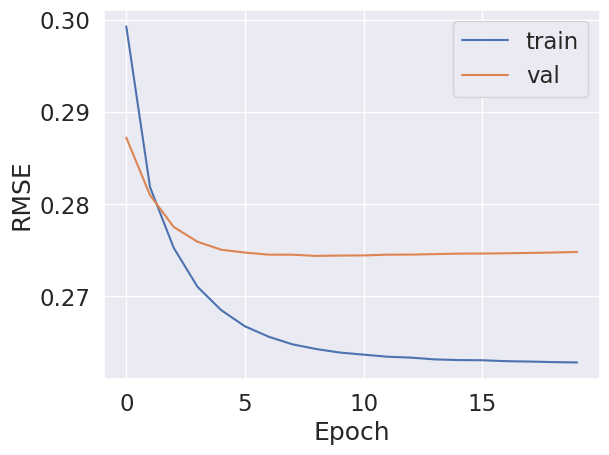

In [ ]:
# Visualisasi
plt.plot(history.history['root_mean_squared_error'], label='train')
plt.plot(history.history['val_root_mean_squared_error'], label='val')
plt.xlabel('Epoch')
plt.ylabel('RMSE')
plt.legend()
plt.show()


In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# Prediksi rating pada data validasi
y_pred = model.predict(x_val).flatten()

# Hitung RMSE dan MAE
rmse = np.sqrt(mean_squared_error(y_val, y_pred))
mae = mean_absolute_error(y_val, y_pred)

print(f"RMSE pada data validasi: {rmse:.4f}")
print(f"MAE pada data validasi: {mae:.4f}")


32695/32695 ━━━━━━━━━━━━━━━━━━━━ 35s 1ms/step
RMSE pada data validasi: 0.2748
MAE pada data validasi: 0.2193


Nilai RMSE dan MAE yang relatif kecil ini menunjukkan model mampu memprediksi rating dengan tingkat akurasi yang baik. Model dapat memahami preferensi pengguna dan memberikan rekomendasi anime yang sesuai dengan minat mereka.